In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import seaborn
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
resolution = 8
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [3]:
import rioxarray
import pathlib
import geopandas
import pandas
import shapely
import numpy

In [4]:
cache_path = pathlib.Path(fr"C:\Local\data\catchments\Westport\caches\NZ20_Westport")
folder = "paper"
dems = {}
dems["Unconditioned"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_unconditioned.nc", masked=True).squeeze("band", drop=True)
dems["Wide uniform flow"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_rupp_and_smart_wide.nc", masked=True).squeeze("band", drop=True)
dems["Wide conceptual multivariate regression"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_rupp_and_smart_narrow.nc", masked=True).squeeze("band", drop=True)
dems["Narrow uniform flow"] = rioxarray.rioxarray.open_rasterio(cache_path / folder  / "geofabric_8m_neal_et_al_wide.nc", masked=True).squeeze("band", drop=True)
dems["Narrow conceptual multivariate regression "] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_neal_et_al_narrow.nc", masked=True).squeeze("band", drop=True)

In [5]:
river_centreline = geopandas.read_file(cache_path / folder / "wide_river" / "aligned_river_centreline_6308000000.geojson")
river_polygon = geopandas.read_file(cache_path / folder / "wide_river" / "river_polygon.geojson")
fan_polygon = geopandas.read_file(cache_path / folder / "wide_river" / "fan_polygon.geojson")

In [6]:
polygon = geopandas.GeoDataFrame( pandas.concat([river_polygon, fan_polygon], ignore_index=True), crs=river_polygon.crs).dissolve()

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [7]:
sections_path = pathlib.Path(fr"C:\Local\data\river_bathemetry\sections\Westport\3738_Buller_River_October_2021")
cross_section_elevation_label = 'Elevation'
cross_section_name_label = 'Name'
measured_sections = geopandas.read_file(sections_path / "3738_Buller_River_October_2021.geojson")
all_measured_sections = ['Section1', 'Section2', 'Section2A', 'Section2B', 'Section3', 'Section3A', 'Section4', 'Section5', 'Section6',
                             'Section7', 'Section8', 'Section9', 'Section10', 'Section11', 'Section12', 'Section13', 'Section14',
                             'Section15', 'Section16', 'Section21', 'Section22', 'Section23', 'Section24', 'Section25', 'Section26', 'Section17',
                             'Section18', 'Section19', 'Section20']
ordered_measured_sections = ['Section1', 'Section2', 'Section2A', 'Section2B', 'Section3', 'Section3A', 'Section4', 'Section5', 'Section6',
                             'Section7', 'Section8', 'Section9', 'Section10', 'Section11', 'Section12', 'Section13', 'Section14',
                             'Section15', 'Section16', 'Section21', 'Section22', 'Section23', 'Section24', 'Section25', 'Section26']

In [8]:
measured_sections.head(1)

,Chainage,Offset,North,East,Elevation,Descriptio,Name,lvd_conversion,z_2016,geometry
0,0,0,5379501.17,1482467.51,0.48,TEMPMARK1LA,Section1,0.363,0.117,POINT Z (1482467.510 5379501.170 0.117)


### Simplify the measured points to min point/line strings

In [9]:
measured_centres = {'Section': [], 'geometry': []}
measured_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections[cross_section_name_label].unique():
    measured_section = measured_sections[measured_sections[cross_section_name_label] == section]
    measured_centre = measured_section[measured_section[cross_section_elevation_label]==measured_section[cross_section_elevation_label].min()].iloc[0]
    measured_centres['Section'].append(section)
    measured_centres['geometry'].append(measured_centre['geometry'])
    
    measured_lines['Section'].append(section)
    measured_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y, measure_point.z] for measure_point in measured_section.geometry.values] ))
    measured_lines['min_elevation'].append(measured_section[cross_section_elevation_label].min())
measured_centres = geopandas.GeoDataFrame(measured_centres, crs=horizontal_crs)
measured_lines = geopandas.GeoDataFrame(measured_lines, crs=horizontal_crs)

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<Axes: >

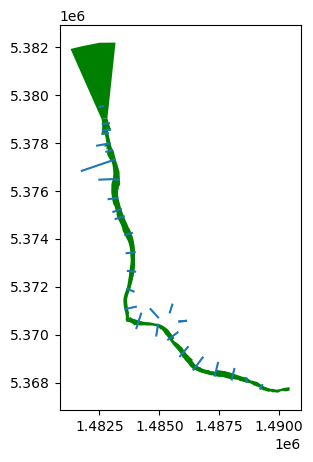

In [10]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
polygon.plot(ax=ax, color='g')
measured_lines.plot(ax=ax)

# Sample every 1m
Use Linear interpolation in between

In [ ]:
comparisons_sampled = {**dict((f"{key} z", []) for key in dems), **{"Measured Section z": [], "Section": [], "River": [], "Distance Upstream [m]": [], "Offset [m]": []}}
for index, row in measured_lines.iterrows():
    print(f"Section number = {index}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(measured_centres.iloc[index].geometry))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        for key in dems:
            comparisons_sampled[f"{key} z"].append(float(dems[key].z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Measured Section z"].append(point.z)
        comparisons_sampled["Section"].append(row['Section'])
        comparisons_sampled["River"].append(polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
        
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

Section number = 0
Section number = 1
Section number = 2
Section number = 3
Section number = 4


# Plot sampled elevations along entire sections
Plot the sampled elevations along individual cross-sections including the on-land portions as a sanity check.

In [ ]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in ordered_measured_sections:
    comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=section)

## Plot elevation errors along each section
95% confidence interval plot for the errors along each section in the river. Plot the spread of 

In [ ]:
for key in dems:
    comparisons_sampled[f"{key} Elevation Errors"] = comparisons_sampled[f"{key} z"] - comparisons_sampled["Measured Section z"]

In [ ]:
comparisons_sampled.head(1)

In [ ]:
comparisons_sampled

In [ ]:
comparisons_sampled.drop(columns=[f"{key} z" for key in dems]).rename(columns=dict((f"{key} Elevation Errors", f"{key}") for key in dems)).rename(columns={"Measured Section z": "Measured Section"}).melt(id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]").head()

In [ ]:
comparisons_for_plotting=comparisons_sampled.drop(
    columns=[f"{key} z" for key in dems]).rename(
    columns=dict((f"{key} Elevation Errors", f"{key}") for key in dems)).rename(
    columns={"Measured Section z": "Measured Section"}).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [ ]:
comparisons_for_plotting.to_json(cache_path / folder / "measured_section_comparison" / "compairson_for_plotting.json")

In [ ]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
seaborn.lineplot(data=comparisons_for_plotting[comparisons_for_plotting["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison").set(title='Section Depths Comparison 95% CI')

In [ ]:
summary = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} z" for key in dems]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
depth_summary = pandas.DataFrame([[summary.mean()[f"{key} Elevation Errors"] for key in dems],
                                  [summary.std()[f"{key} Elevation Errors"] for key in dems]],
                                  index = ["Mean Error", "Standard Deviation"], columns=[key for key in dems])
depth_summary

# Channel Area error
The total area of the channel at each section

In [ ]:
channel_depths = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=["Unconditioned DEM Elevation Errors", "Conditioned Neal DEM Elevation Errors", "Conditioned Smart DEM Elevation Errors", "River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
section_max_evaluation = channel_depths.groupby("Distance Upstream [m]")[["Measured Section z"]].max()

In [ ]:
channel_depths.head(1)

In [ ]:
# Some hacky code to subtract the max elevation from each column in turn
channel_depths["Measured Section"] = section_max_evaluation - channel_depths[["Measured Section z"]]
channel_depths["Unconditioned DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Unconditioned DEM z"}) - channel_depths[["Unconditioned DEM z"]]
channel_depths["Uniform Flow DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Conditioned neal DEM z"}) - channel_depths[["Conditioned neal DEM z"]]
channel_depths["Multivariate Regression DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Conditioned smart DEM z"}) - channel_depths[["Conditioned smart DEM z"]]
channel_depths.head(1)

In [ ]:
channel_area = channel_depths.drop(
    columns=["Measured Section z", "Unconditioned DEM z", "Conditioned neal DEM z", "Conditioned smart DEM z"]).groupby("Distance Upstream [m]").sum()
channel_area.head(1)

In [ ]:
areas_for_plotting=channel_area.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

In [ ]:
seaborn.set(rc={'figure.figsize':(15,7.5)})
seaborn.lineplot(data=areas_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source").set(title='Channel Area Comparison')

In [ ]:
unconditioned_error = channel_area["Unconditioned DEM"]-channel_area["Measured Section"]
conditioned_neal_error = channel_area["Uniform Flow DEM"]-channel_area["Measured Section"]
conditioned_smart_error = channel_area["Multivariate Regression DEM"]-channel_area["Measured Section"]

area_summary = pandas.DataFrame([[unconditioned_error.mean(), conditioned_neal_error.mean(), conditioned_smart_error.mean()], [unconditioned_error.std(), conditioned_neal_error.std(), conditioned_smart_error.std()]], 
                                index = ["Mean Error", "Standard Deviation"], columns=["Unconditioned DEM", "Uniform Flow DEM", "Multivariate Regression DEM"])
area_summary

In [ ]:
pandas.DataFrame([[summary.mean()["Unconditioned DEM Elevation Errors"], summary.mean()["Conditioned Neal DEM Elevation Errors"], summary.mean()["Conditioned Smart DEM Elevation Errors"]],
                  [summary.std()["Unconditioned DEM Elevation Errors"], summary.std()["Conditioned Neal DEM Elevation Errors"], summary.std()["Conditioned Smart DEM Elevation Errors"]],
                  [unconditioned_error.mean(), conditioned_neal_error.mean(), conditioned_smart_error.mean()], 
                  [unconditioned_error.std(), conditioned_neal_error.std(), conditioned_smart_error.std()]], 
                 index = [["Bed Elevations", "Bed Elevations", "Cross-sectional Areas", "Cross-sectional Areas"],
                          ["Mean Error [m]", "Standard Deviation", "Mean Error [m^2]", "Standard Deviation"]], 
                 columns=["Unconditioned DEM", "Uniform Flow DEM", "Multivariate Regression DEM"])

# Plot difference in area plot

In [ ]:
channel_area_difference = pandas.DataFrame()
channel_area_difference["Unconditioned DEM"] = channel_area["Unconditioned DEM"]-channel_area["Measured Section"]
channel_area_difference["Uniform Flow DEM"] = channel_area["Uniform Flow DEM"]-channel_area["Measured Section"]
channel_area_difference["Multivariate Regression DEM"] = channel_area["Multivariate Regression DEM"]-channel_area["Measured Section"]
channel_area_difference.head(1)

In [ ]:
area_diffs_for_plotting=channel_area_difference.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Cross-sectional Area [m^2]")
area_diffs_for_plotting.head(2)

In [ ]:
seaborn.set(rc={'figure.figsize':(15,7.5)})
seaborn.lineplot(data=area_diffs_for_plotting, x="Distance Upstream [m]", y="Cross-sectional Area [m^2]", hue="Source").set(title='Channel Area Error')